In [1]:
import sys
import os

from archai.datasets.cv.mnist_dataset_provider import MnistDatasetProvider

dataset_provider = MnistDatasetProvider()
tr_data = dataset_provider.get_train_dataset()

sys.path.append(os.path.realpath('scripts'))

In [2]:
import numpy as np
shape = tr_data.data[0].shape
shape = [1,1] + list(shape)
print(shape)

[1, 1, 28, 28]


In [3]:
import math
import torch
from torch import nn
from model import MyModel
from archai.datasets.cv.mnist_dataset_provider import MnistDatasetProvider
from store import ArchaiStore
import tqdm

class Trainer:
    def __init__(self, training_epochs: float = 1.0, lr: float = 1e-4, device: str = 'cpu'):
        self.training_epochs = training_epochs
        self.device = device
        self.lr = lr
        self.model = None
        self.val_acc = None
        self.shape = None

    def evaluate(self, model, dataset_provider, progress_bar=False) -> float:
        # Loads the dataset
        tr_data = dataset_provider.get_train_dataset()
        val_data = dataset_provider.get_val_dataset()

        self.shape = tr_data[0][0].shape

        tr_dl = torch.utils.data.DataLoader(tr_data, batch_size=16, shuffle=True, num_workers=4)
        val_dl = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=False, num_workers=4)

        # Training settings
        optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()

        model.train()
        model.to(self.device)

        # Partial training
        epoch_iter = range(math.ceil(self.training_epochs))
        if progress_bar:
            epoch_iter = tqdm(epoch_iter, desc=f'Training model {model.archid}')
        for epoch_nb in epoch_iter:
            # Early stops for fractional values of training epochs (e.g, 0.2)
            early_stop = len(tr_dl) + 1
            if 0 < (self.training_epochs - epoch_nb) < 1:
                early_stop = int((self.training_epochs - epoch_nb) * len(tr_dl))

            for i, (x, y) in enumerate(tr_dl):
                if i >= early_stop:
                    break

                optimizer.zero_grad()

                pred = model(x.to(self.device))
                loss = criterion(pred, y.to(self.device))

                loss.backward()
                optimizer.step()

        # Evaluates final model
        model.eval()

        with torch.no_grad():
            val_pred, val_target = [], []

            for x, y in val_dl:
                val_pred.append(model(x.to(self.device)).argmax(axis=1).to('cpu'))
                val_target.append(y.to('cpu'))

            val_pred, val_target = torch.cat(val_pred, axis=0), torch.cat(val_target, axis=0)
            val_acc = (val_pred.squeeze() == val_target.squeeze()).numpy().mean()

        # Returns model to cpu
        model.cpu()

        self.model = model
        self.val_acc = val_acc
        return val_acc


In [4]:
model = MyModel()
dataset_provider = MnistDatasetProvider()
trainer = Trainer(training_epochs=10, device='cuda')
trainer.evaluate(model, dataset_provider, True)

0.9867

In [23]:
import numpy as np
shape = tr_data.data[0].shape
shape = [1,1] + list(shape)
print(shape)

dummy_input = torch.randn(shape, device="cpu")
torch.onnx.export(model.model, dummy_input, "model.onnx",
                  input_names = ['input'],  
                  output_names = ['output']) 

[1, 1, 28, 28]


0.9867


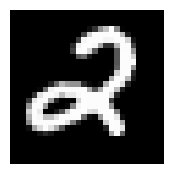

Testing 10000 rows
### Failed: 1 and got 7 - seven
### Failed: 0 and got 2 - two
### Failed: 4 and got 7 - seven
### Failed: 4 and got 7 - seven
### Failed: 9 and got 2 - two
### Failed: 5 and got 2 - two
### Failed: 9 and got 2 - two
### Failed: 0 and got 2 - two
### Failed: 6 and got 2 - two
### Failed: 9 and got 7 - seven
### Failed: 0 and got 2 - two
### Failed: 5 and got 2 - two
### Failed: 9 and got 7 - seven
### Failed: 3 and got 2 - two
### Failed: 4 and got 2 - two
### Failed: 9 and got 2 - two
### Failed: 6 and got 2 - two
### Failed: 6 and got 2 - two
### Failed: 5 and got 2 - two
### Failed: 4 and got 2 - two
### Failed: 0 and got 2 - two
### Failed: 4 and got 7 - seven
### Failed: 0 and got 2 - two
### Failed: 3 and got 2 - two
### Failed: 3 and got 2 - two
### Failed: 4 and got 2 - two
### Failed: 7 and got 2 - two
### Failed: 7 and got 2 - two
### Failed: 3 and got 2 - two
### Failed: 4 and got 2 - two
### Failed: 6 and got 2 - two
### Failed: 5 and got 2 - two
### Faile

In [69]:
import onnxruntime as ort
import numpy as np

print (trainer.val_acc)
val_data = dataset_provider.get_val_dataset()
count = val_data.data.shape[0]
test = np.random.choice(count, 1)[0]
data = val_data.data[test]

import matplotlib.pyplot as plt

plt.figure(figsize=(2,2))
plt.imshow(data, cmap='gray')
plt.axis('off')
plt.show()

ort_sess = ort.InferenceSession('model.onnx', providers=['CPUExecutionProvider'])

print(f'Testing {count} rows')
failed = 0
for i in range(val_data.data.shape[0]):
    data = val_data.data[i]
    expected = int(val_data.train_labels[i])

    while len(data.shape) < 4:
        data = np.expand_dims(data, axis=0)
    outputs = ort_sess.run(None, {'input': data.astype(np.float32)})
    result = outputs[0]
    index = np.argmax(result)
    label = val_data.classes[index]
    if expected != index:
        print(f'### Failed: {expected} and got {label}')
        failed += 1
          
print("")
rate = (count - failed) * 100 / count
print(f'Pass rate is  {rate} %')

In [71]:
import uuid

str(uuid.uuid4())

'6ab6df2e-c3cd-44da-92e8-5a76957fb639'